# Import Packages

In [28]:
import pandas as pd
import os
import numpy as np
from sklearn.mixture import GaussianMixture

#Own packages
import louvainFunctions_v3 as lF
# import gmm
import markergeneFunctions as mgF
import plotumapFunctions as puF
import evaluation as ev
import gnbFunctions as gnb

# Pre-process data and dimensionality reduction
## Do not run this cell, it is only here as a part of the pipeline.
Log transform and normalization, dimensionality reduction using PCA


In [ ]:
data = np.loadtxt("../output/data_loaded.csv", dtype=float, delimiter=",")
data[data == 0.0] = 0.0000001
print("Data is loaded. Now taking log-transform. ")

data = log_transform(data)
print("Data is transformed. Now scaling.")

data = scale(data)
print("Data is mean-centred. Now performing PCA.")

variances, reduced_data = perform_pca(data)
print("PCA successful! Now saving data.")

sample = reduced_data[:500, :]
np.savetxt("../output/reduced_sample_20_PCs.csv", sample, delimiter=",", fmt="%.2f")

np.savetxt("../output/reduced_data_20_PCs.csv", reduced_data, delimiter=",", fmt="%.2f")
print("Data saved! Now plotting.")

# Load Data

In [12]:
dirpath = None
dirpath = r'C:\Users\Asus\OneDrive\Documents\YEAR 1\ML\Project\02620_Project' # Path To Directory.
if dirpath is None:
    raise Exception(r'MAKE DIRPATH YOUR DIRECTORY SUCH THAT THE FOLDER "data" IS IN THE DIRECTORY')
os.chdir(dirpath)

In [13]:
data = np.loadtxt(os.path.join(r'.\data', 'reduced_sample_20_PCs.csv'), delimiter=',')
print(data.shape)

(500, 20)


In [40]:
#import larger dataset
large_data = np.loadtxt(os.path.join(r'.\data', 'reduced_data_20_PCs.csv'), delimiter=',')
print(large_data.shape)

(16155, 20)


# Test against GMMs from package

In [14]:
from sklearn.mixture import GaussianMixture

membership_arr_gmm_small = GaussianMixture(n_components=14, random_state=0, n_init = 20).fit_predict(data)
save_dir = os.path.join(os.getcwd(), 'output')
save_path = os.path.join(save_dir, 'gmm_clusters.txt')
np.savetxt(save_path, membership_arr_gmm_small[np.newaxis, :], fmt = '%d')
np.save('membership_arr_gmm.npy', membership_arr_gmm_small)

C:\Users\Asus\Anaconda3\envs\mlproject\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Asus\Anaconda3\envs\mlproject\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Asus\Anaconda3\envs\mlproject\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Asus\Anaconda3\envs\mlproject\lib\site-packages\sklearn\cluster\_kmeans.py:1382: User

# Run Louvain
Will create an array of labels with dimensions (# of samples,)

In [7]:
membership_arr_louvain_small = lF.louvain_clustering(data, k=5)
np.save('membership_arr_louvain.npy', membership_arr_louvain_small)

Starting Louvain clustering


In [43]:
membership_arr_louvain = lF.louvain_clustering(large_data, k=20)
np.save('membership_arr_louvain_large.npy', membership_arr_louvain)

Starting Louvain clustering


# Test against Louvain from package

import networkx as nx
import networkx.algorithms.community as nx_comm

from louvainFunctions import create_kNN_graph
edge_list, edge_weights = create_kNN_graph(data, 5)
G=nx.Graph()
G.add_edges_from(edge_list)

#first compute the best partition
partition = nx_comm.louvain_communities(G)

membership_arr_package = np.zeros((len(data)))
for i in range(len(partition)):
    for n in partition[i]:
        membership_arr_package[n] = i

# Plot UMAP

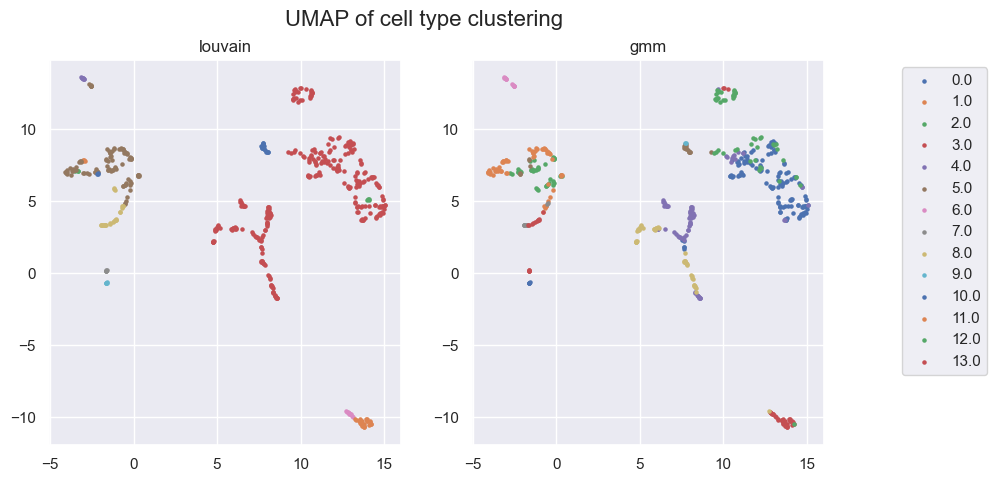

In [27]:
puF.plot_umap(data, [membership_arr_louvain_small, membership_arr_gmm_small], ['louvain', 'gmm'])

# Get Marker Genes and plot violin plots

Will save a dictonary of marker genes for each cluster and plot violin plots for top 3 genes for each cluster. Requires original data before dimension reduction. Have not tested on this dataset.

In [47]:
data_file = os.path.join(r'./data', 'data_mtg_loaded.hdf5')
clusters = np.unique(membership_arr_gmm)
median_arr, mean_arr = mgF.get_gene_stats_by_cluster(data_file, membership_arr_louvain.reshape(-1), clusters)
mgF.filter_genes_by_median(median_arr, mean_arr)
mgF.plot_marker_genes(data_file, clusters, membership_arr_louvain.reshape(-1), save_dir = save_dir)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './data\data_mtg_loaded.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Evaluate performance

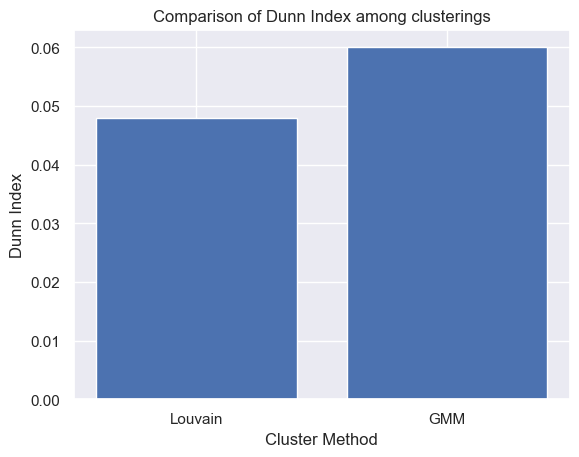

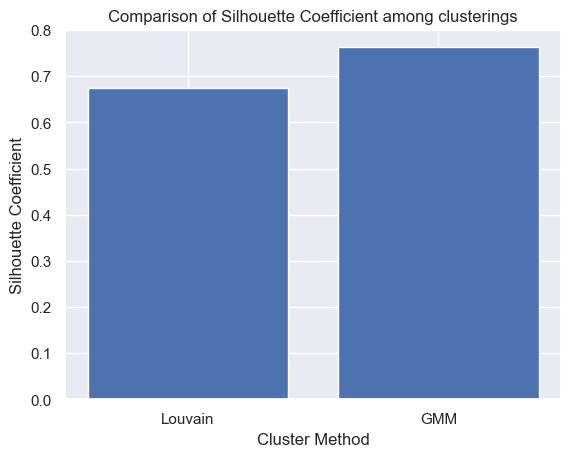

<Figure size 640x480 with 0 Axes>

In [17]:
louvain_centres = ev.calculate_cluster_centroids(membership_arr_louvain, data)
louvain_di = ev.dunn_index(membership_arr_louvain, data, louvain_centres)
louvain_sc = ev.silhouette_coefficient(membership_arr_louvain, data, louvain_centres)

gmm_centres = ev.calculate_cluster_centroids(membership_arr_gmm, data)
gmm_di = ev.dunn_index(membership_arr_gmm, data, gmm_centres)
gmm_sc = ev.silhouette_coefficient(membership_arr_gmm, data, gmm_centres)

di = np.asarray([louvain_di, gmm_di])
sc = [louvain_sc, gmm_sc]

ev.plot_evaluation_metric(di, ['Louvain','GMM'], "Dunn Index", output_folder = './output')
ev.plot_evaluation_metric(
        sc, ['Louvain', 'GMM'], "Silhouette Coefficient", output_folder = './output')

# Gaussian Naive Bayes

In [36]:
import importlib
importlib.reload(gnb)

#Run GNB on Louvain labels
X = data
y = np.array([int(n) for n in membership_arr_louvain])
features = [x for x in range(X.shape[1])]
classes = np.unique(y)

X_train, X_test, y_train, y_test = gnb.train_test_split(X, y, test_size = 0.3, random_state = 0, stratify=y)

priors_data = gnb.calculate_class_priors(y_train)
param = gnb.calculate_param(X_train, y_train)
pred_pca = np.array(gnb.predict(X_test, features, classes, priors_data, param))
print("GNB accuracy on 500 points:", gnb.accuracy_score(pred_pca, y_test))

GNB accuracy trained on 500 points, tested on 500 points: 91.33


In [46]:
#predict on large data. Priors_data and Param are from the previous cell.
X_large = large_data
y = np.array([int(n) for n in membership_arr_louvain])
features = [x for x in range(X_large.shape[1])]
classes = np.unique(y)

X_train, X_test, y_train, y_test = gnb.train_test_split(X_large, y, test_size = 0.3, random_state = 0, stratify=y)

priors_data = gnb.calculate_class_priors(y_train)
param = gnb.calculate_param(X_train, y_train)
pred_pca = np.array(gnb.predict(X_test, features, classes, priors_data, param))
print("GNB accuracy on 16155 points:", gnb.accuracy_score(pred_pca, y_test))

GNB accuracy on 16155 points: 99.15
